In [7]:
import numpy as np
import cv2
import io
import PIL.Image
import math
import glob
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display
from keras.models import load_model
from util.WordSegmentation import wordSegmentation, prepareImg
from sklearn.preprocessing import normalize
from natsort import natsorted
from keras.backend.tensorflow_backend import set_session

In [8]:
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

In [9]:
class_names = [
    "Alef",
    "Ayin",
    "Bet",
    "Dalet",
    "Gimel",
    "He",
    "Het",
    "Kaf",
    "Kaf-final",
    "Lamed",
    "Mem",
    "Mem-medial",
    "Nun-final",
    "Nun-medial",
    "Pe",
    "Pe-final",
    "Qof",
    "Resh",
    "Samekh",
    "Shin",
    "Taw",
    "Tet",
    "Tsadi-final",
    "Tsadi-medial",
    "Waw",
    "Yod",
    "Zayin"
]

In [10]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [12]:
model = load_model('neural_net_models/lenet5.best.hdf5')
# new_model = tf.keras.experimental.load_from_saved_model(saved_model_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               86520     
______________________

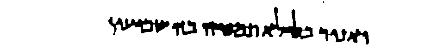

In [13]:
import_images = []
import_images.append(prepareImg(cv2.imread('input_files_word_old/slice4.png'), 50))
showarray(import_images[0])

In [14]:
input_files = 'output_files/image-data/'

def load_slices(filepath):
    slices = []
    slices_filepath = filepath + '/'
    slices_path = natsorted(glob.glob(slices_filepath + 'slice*_binarize.png'))
    for slice_path in slices_path:
        slices.append(prepareImg(cv2.imread(slice_path), 50))  
    #print(len(slices))
    return slices

image_filepaths = glob.glob(input_files + '*')
print(image_filepaths[len(image_filepaths) - 5])
images = []
for image_filepath in image_filepaths:
    images.append(load_slices(image_filepath))


output_files/image-data/P583-Fg002-R-C01-R01-fused


In [15]:
#Count the number of black pixels in an image and return a float with the density
def pixel_density(image):
    area = float(image.shape[0]*image.shape[1])
    blackPixels = float(np.sum(image == 0))
    density = blackPixels/area
    return density

In [16]:
"""
res = []
words = []
for i, img in enumerate(import_images):
    res = wordSegmentation(img, kernelSize=5, sigma=5, theta=7, minArea=30) # fix parameters
"""

'\nres = []\nwords = []\nfor i, img in enumerate(import_images):\n    res = wordSegmentation(img, kernelSize=5, sigma=5, theta=7, minArea=30) # fix parameters\n'

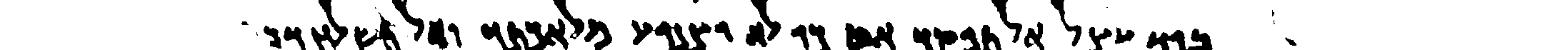

In [17]:
#There still needs to come a loop through all the slices, here you can pick a slice to debug
img = images[1][5]
showarray(img)
#Parameters are optimized. 
res = wordSegmentation(img, kernelSize=5, sigma=5, theta=7, minArea=100) 

In [18]:
words = []
for (j, w) in enumerate(res):
    (wordBox, wordImg) = w
    (x, y, w, h) = wordBox
    if (w > 15):
        if( h > 15):
            words.append(wordImg)

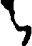

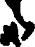

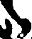

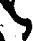

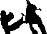

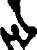

In [19]:
words.reverse()
for word in words:
    showarray(word)

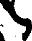

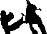

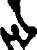

In [20]:
#Look for the bounding boxes over the words again to possible find characters. It will return the box of the entire word
#when it does not find seperate characters in the word. 
#The character needs a minimum width of 15, height of 10 and maximum density of 55%
characters = []
temp = []
for word in words:
    res = wordSegmentation(word, kernelSize=3, sigma=1, theta=1, minArea=15) # fix parameters

    for (j, w) in enumerate(res):
        (charBox, charImg) = w
        (x, y, w, h) = charBox
        if (w > 15):
            if( h > 15):
                if( pixel_density(charImg) < 0.55):
                    characters.append(charImg)

for char in characters:
    showarray(char)
    #print(pixel_density(char))

##### word = words[2]
h, w = word.shape
num = 4
chars = []
for i in range(num):
    part = math.floor(w / num)
    char = word[:,part * i:(part * i) + part]
    shape = cv2.resize(char,(32,48))
    ret,thresh1 = cv2.threshold(shape,127,255,cv2.THRESH_BINARY)
    chars.append(thresh1)

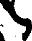

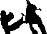

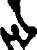

In [21]:
chars = characters
for char in chars:
    showarray(char)

In [22]:
fonts = []
for item in class_names:
    fonts.append(cv2.imread('habbakuk/' + item + '/standard.png'))

In [23]:
for char in chars:
#     char_pred = cv2.cvtColor(char, cv2.COLOR_BGR2GRAY)
    char_pred = np.asarray(char[:], dtype='float32')
    print(char_pred.shape)
    char_pred = normalize(char_pred)
    char_pred = char_pred.reshape(-1, 48, 32,1)

    prediction = model.predict([char_pred])
    for i in range(len(prediction)):
        print('Predicted: ', prediction[i] * 100)
    highest_index = np.argmax(prediction)
    print('Index of class with highest probability: ',highest_index)
    print('Value of highest probability: ', prediction[0][highest_index])
    print('Name of predicted class: ', class_names[highest_index])
    print('habbabuk/' + class_names[highest_index] + '/standard.png')
    character_example = cv2.imread('habbakuk/' + str(class_names[highest_index]) + '/standard.png')
    showarray(character_example)
    showarray(char)

(21, 66)


ValueError: cannot reshape array of size 1386 into shape (48,32,1)

In [ ]:
# for box in bounding_boxes:
#     xStart = box[2]
#     xEnd = box[0]
#     y = box[1]
#     winH = box[3] - y
#     winWidth = 5
#     while(xStart-winWidth >= xEnd) :
#         hit = False
#         winW = winWidth
#         a = 0
#         # While the image is not classified and the box has not reached the edge,
#         # increase window size
#         while(not hit and xStart-winW >= xEnd) :
#             newX = xStart - winW
#             # Draw the window
#             clone = img.copy()
#             cv2.rectangle(clone, (xStart, y), (newX, y + winH), (255, 0, 0), 2)
#             cv2.rectangle(clone, (xStart,y),(xEnd,y + winH), (0,255,0), 2)
#             cv2.imshow("Window", clone)
#             cv2.waitKey(0)
#             # Check if the CNN returns a high probability for a letter
#             # for prob in probabilities :
#             #     if prob >= 0.75 :
#             #         hit = True
#             #         xStart = newX
#             # # Increase size of window if nothing has been found
#             winW += 5
#             # this is done to ensure that the loop ends for now, because not
#             # connected to cnn yet.
#             hit = True
#             xStart = newX

In [ ]:
# def get_resized_img(img, video_size):
#     width, height = video_size  # these are the MAX dimensions
#     video_ratio = width / height
#     img_ratio = img.size[0] / img.size[1]
#     if video_ratio >= 1:  # the video is wide
#         if img_ratio <= video_ratio:  # image is not wide enough
#             width_new = int(height * img_ratio)
#             size_new = width_new, height
#         else:  # image is wider than video
#             height_new = int(width / img_ratio)
#             size_new = width, height_new
#     else:  # the video is tall
#         if img_ratio >= video_ratio:  # image is not tall enough
#             height_new = int(width / img_ratio)
#             size_new = width, height_new
#         else:  # image is taller than video
#             width_new = int(height * img_ratio)
#             size_new = width_new, height
#     return np.asarray(img.resize(size_new, resample=Image.LANCZOS))

In [ ]:
# char = cv2.cvtColor(char, char, cv2.COLOR_BGR2GRAY)